<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Hidden Markov Models Tutorial</h1> 
<h3 align="center">Summer Workshop on the Dynamic Brain</h3> 
<h3 align="center">Friday, August 26th, 2022</h3> 
<h4 align="center">Scott Linderman</h4> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>This notebook will introduce you to hidden Markov models (HMMs), a type of probabilistic state space model. HMMs are models for sequential data, like a neural spike train or a behavioral time series. The key idea is that the observed data arises from an underlying sequence of <i>discrete latent states</i>. For example, maybe a neural population switches between an up and down state; or maybe a mouse switches between an attentive and inattentive state, which manifests in its behavior. By the end of this tutorial, you will have tools to infer these states from observed data.
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <p>We'll use a software library called <a href="https://github.com/probml/ssm-jax">SSM-JAX</a>, which I am developing along with a team of researchers and summer students at Google. Eventually, I plan to deprecate my lab's <a href="https://github.com/lindermanlab/ssm/">SSM</a> library with this one, which uses <a href="https://github.com/google/jax">JAX</a>, a streamlined and improved version of TensorFlow.
</div>

In [1]:
%pip install -U -q git+https://github.com/probml/ssm-jax.git@swdb

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import trange

%matplotlib inline

# 1. Simulate data from a Poisson HMM

As a warm-up, let's simulate a simple neuron that switches between an "up" state (1) and a "down" state (0). In the up state, the neuron fires at a rate of $\lambda_1 = 50$ spikes/sec, and in the down state the neuron fires at a rate of $\lambda_0=10$ spikes/sec. Assume that have binned time into $\Delta = 25$ms bins. 

Let $z_t \in \{0, 1\}$ denote the discrete latent state in time bin $t$, and let $x_t \in \mathbb{N}$ denote the number of spikes the neuron fired in that bin. Assume that the spike counts are conditionally distributed according to a Poisson distribution, given the discrete latent state,
\begin{align*}
x_t \mid z_t &\sim \mathrm{Po}(\lambda_{z_t} \cdot \Delta)
\end{align*}

Furthermore, assume that the discrete states tend to persist for a number of time bins before switching. We can model that with a transition distribution that places high probability on self-transitions ($z_{t+1} = z_t$).
\begin{align*}
p(z_{t+1} \mid z_t) &= 
\begin{cases}
0.9 &\text{if } z_{t+1} = z_t \\
0.1 &\text{if } z_{t+1} \neq z_t \\
\end{cases}
\end{align*}
We can represent the transtion probabilities as a matrix $P$ where the entry $P_{ij} = p(z_{t+1} = j \mid z_t = i)$. In this case,
\begin{align*}
P &= \begin{bmatrix} 0.9 & 0.1 \\ 0.1 & 0.9 \end{bmatrix}
\end{align*}

Finally, assume the initial state is drawn from a uniform distribution, $p(z_1 = 0) = p(z_1 = 1) = 0.5$.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem 1:</b> Simulate 10 seconds of data of a neuron according to this 2-state HMM. <i>Hint:</i> Use <code>npr.choice</code> to sample the discrete states and <code>npr.poisson</code> to sample the spike counts.
</div>

In [7]:
# Uncomment and run the following line to get help with the `choice` function.
npr.choice?

In [8]:
# Uncomment and run the following line to get help with the `poisson` function.
npr.poisson?

In [66]:
npr.seed(1)

# Compute the integer number of time bins in the simulation
bin_size = 0.025  # in sec
total_time = 10.0  # in sec
num_timebins = int(total_time // bin_size + 1) # TODO

# Specify the number of neurons
num_neurons = 100

# Set the model parameters
initial_distribution = np.array([0.5, 0.5])
transition_matrix = np.array([[0.9, 0.1], 
                              [0.1, 0.9]])
firing_rates = np.array([[10.], 
                         [50.]])


In [67]:
# Initialize the outputs
states = np.zeros(num_timebins, dtype=int)
spike_counts = np.zeros((num_timebins, num_neurons), dtype=int)

# Sample the first state and observation
states[0] = npr.choice(2,p=initial_distribution)        
spike_counts[0] = npr.poisson(firing_rates[states[0]]*bin_size)   

# Sample subsequent time steps
for t in range(1, num_timebins):
    states[t] =  npr.choice(2,p=transition_matrix[states[t-1]])        
    spike_counts[t] =  npr.poisson(firing_rates[states[t]]*bin_size)  

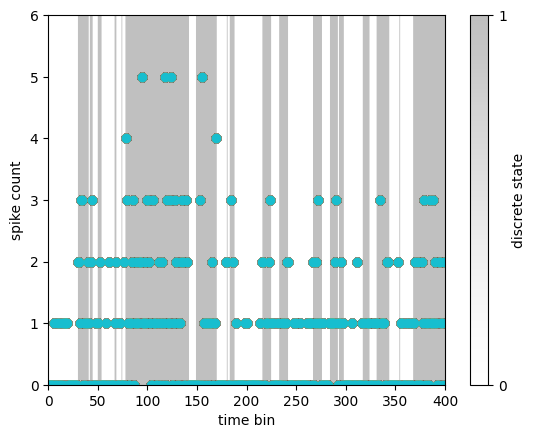

In [68]:
# Plot the simulated data
plt.imshow(states[None, :], cmap="Greys", alpha=0.25, aspect="auto", 
           extent=(0, num_timebins, 0, 6))
plt.plot(spike_counts, 'o')
plt.xlabel("time bin")
plt.ylabel("spike count")

cb = plt.colorbar()
cb.set_label("discrete state")
cb.set_ticks([0, 1])

# 2. Fitting an HMM to data with Expectation-Maximization
Let's see if we can recover the model parameters and most likely states.

In [56]:
import jax.numpy as jnp
import jax.random as jr

from ssm_jax.hmm.models import PoissonHMM

In [57]:
# The fitting code assumes that you give it a batch of time series, so the first
# thing we'll do is add an extra dimension
batch_of_spike_counts = jnp.array([spike_counts])    #batch size (number of neurons = 1)
print(batch_of_spike_counts.shape) 
# Output: (batch size, num_timebins, num_neurons)

(1, 400, 1)


In [58]:
# Initializing an HMM model with poisson model, 

# Construct an HMM with Poisson emissions using randomly initialized parameters
hmm = PoissonHMM.random_initialization(jr.PRNGKey(0), num_states=2, emission_dim=1)
# jr.PRNGKey is to randomize

# Now fit the HMM using expectation-maximization (EM)!
lps = hmm.fit_em(batch_of_spike_counts, num_iters=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0, 0.5, 'Log Probability')

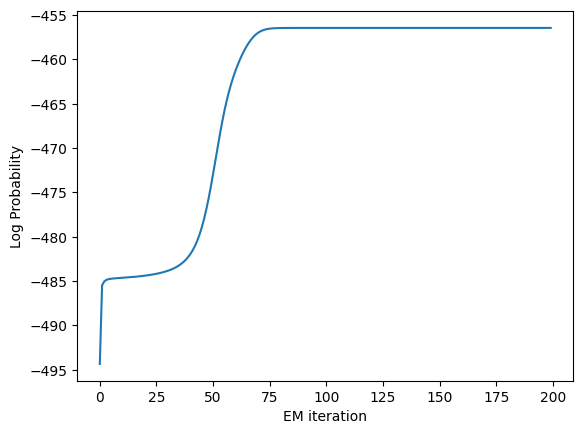

In [59]:
plt.plot(lps)
plt.xlabel("EM iteration")
plt.ylabel("Log Probability")

In [62]:
# Look at the estimated parameters
print("estimated rates: ")
print(hmm.emission_rates.value / bin_size)
print("")
print("estimated transition matrix: ")
print(hmm.transition_matrix.value)

estimated rates: 
[[49.887733]
 [10.528359]]

estimated transition matrix: 
[[0.9235567  0.07644334]
 [0.07390045 0.92609954]]


(0.0, 200.0)

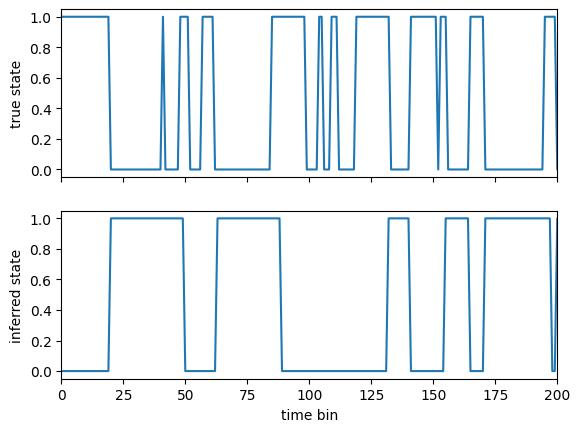

In [63]:
# Find the most likely discrete states given the learned model parameters
most_likely_states = hmm.most_likely_states(spike_counts)

# Compare the true and inferred states
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(states)
axs[0].set_ylabel("true state")
axs[1].plot(most_likely_states)
axs[1].set_ylabel("inferred state")
axs[1].set_xlabel("time bin")
plt.xlim(0, 200)

The HMM yields more than just the most likely states, it gives a full posterior distribution over states. The posterior probabilities are the results of running the HMM **smoother** to compute $p(z_t \mid x_{1:T})$ for each time bin $t$. 

(0.0, 200.0)

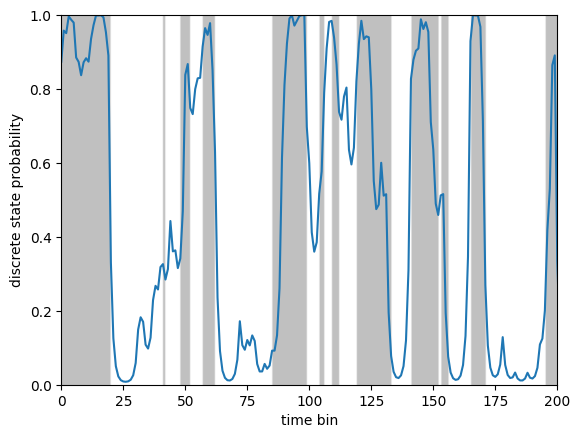

In [64]:
# Find the posterior distribution over states
posterior = hmm.smoother(spike_counts)

# Compare the true and inferred states
plt.imshow(states[None, :], cmap="Greys", alpha=0.25, aspect="auto", 
           extent=(0, num_timebins, 0, 1))
plt.plot(posterior.smoothed_probs[:, 0])
plt.xlabel("time bin")
plt.ylabel("discrete state probability")
plt.xlim(0, 200)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem 2.1:</b> Did the model recover the true states? How close should we expect it to get?
</div>

In [ ]:
# the model leaves out the granual changes in states, but also invereted the assignment: state 1 or 0 is randomly assigned

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem 2.2:</b> What changes to the parameters would make the states easier or harder to infer? Why?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem 2.3:</b> Change the simulation code to simulate multiple neurons that all share the same underlying discrete state. 
</div>

That is, let $\mathbf{x}_t = (x_{t1}, \ldots, x_{tN})^\top$ denote a vector of spike counts for each of $N$ neurons in time bin $t$. Assume the neurons' spike counts are conditionally independent Poisson random variables given the discrete state,
\begin{align*}
    p(\mathbf{x}_t \mid z_t) &= \prod_{n=1}^N \mathrm{Po}(x_{tn} \mid \lambda_{z_t,n} \Delta)
\end{align*}
where $\lambda_{z_t,n} \in \mathbb{R}_+$ is the firing of neuron $n$ in state $z_t$.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem 2.4:</b> Would adding more neurons make the discrete states harder or easier to infer? Why?
</div>

# 3. Load and preprocess the Visual Behavior Neuropixels data

Next, we'll develop a simple model of the licking behavior in the visual behavior dataset. Alex Piet at the Allen Institute has developed similar models to look for changes in the animals' internal state.

In [69]:
import platform
platstring = platform.platform()

data_dirname = 'visual-behavior-neuropixels'
use_static = False
if 'Darwin' in platstring or 'macOS' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/"
    data_dirname = 'visual-behavior-neuropixels-data'
    use_static = True
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/"

In [70]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

# this path should point to the location of the dataset on your platform
cache_dir = os.path.join(data_root, data_dirname)

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=use_static)

In [71]:
# Load our favorite session (the one from the VBN tutorial!)
session_id = 1053941483
session = cache.get_ecephys_session(
            ecephys_session_id=session_id)
session.metadata

/Users/christinejunhuiliu/opt/anaconda3/envs/swdb2022/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


{'equipment_name': 'NP.1',
 'sex': 'M',
 'age_in_days': 180,
 'stimulus_frame_rate': 60.0,
 'session_type': 'EPHYS_1_images_H_3uL_reward',
 'date_of_acquisition': datetime.datetime(2020, 10, 2, 0, 3, 58, tzinfo=tzutc()),
 'reporter_line': 'Ai32(RCL-ChR2(H134R)_EYFP)',
 'cre_line': 'Sst-IRES-Cre',
 'behavior_session_uuid': None,
 'driver_line': ['Sst-IRES-Cre'],
 'mouse_id': 527749,
 'full_genotype': 'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
 'behavior_session_id': 1053960987,
 'ecephys_session_id': 1053941483}

### Get the active stimulus presentations (aka flashes) and lick data
We'll only study the active flashes in this tutorial, since we'll be modeling the licking data.

In [72]:
licks = session.licks
flashes = session.stimulus_presentations[session.stimulus_presentations.active].copy()

### Find the onset of lick bouts

Licks come in short bouts. Find the first lick in each bout. Then, for each flash, add a boolean flag to specify if the mouse started a lick bout following that presentation. 

In [73]:
lick_times = licks.timestamps.values
lick_intervals = np.concatenate([[np.inf], np.diff(lick_times)])
is_bout_start = lick_intervals > 3 * np.median(lick_intervals[1:])
bout_start_times = lick_times[is_bout_start]
flashes['licked'] = flashes.apply(
    lambda row: np.sum((bout_start_times > row["start_time"]) & \
                       (bout_start_times < row["start_time"] + 0.75)) > 0,
    axis=1,
)

## Visualize the mouse's performance over the session

Text(0.5, 0, 'flash index')

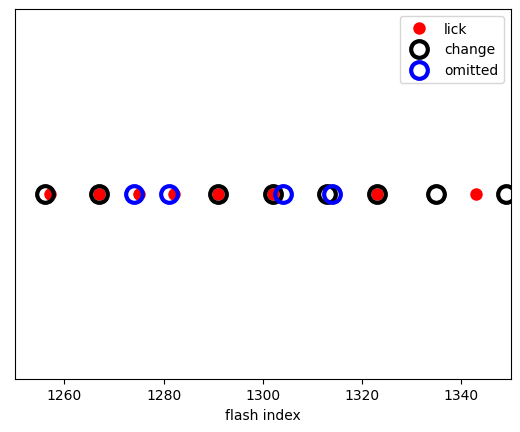

In [74]:
change_idxs = np.where(flashes.is_change)[0]
omitted_idxs = np.where(flashes.omitted)[0]
lick_idxs = np.where(flashes.licked)[0]
plt.plot(lick_idxs, np.ones_like(lick_idxs), 'ro', ms=10, mec='w', label="lick")
plt.plot(change_idxs, np.ones_like(change_idxs), 'o', mec='k', mfc='none', ms=12, mew=3, label="change")
plt.plot(omitted_idxs, np.ones_like(omitted_idxs), 'o', mec='b', mfc='none', ms=12, mew=3, label="omitted")
plt.xlim(1250, 1350)
plt.yticks([])
plt.legend()
plt.xlabel("flash index")

### Extract some summary statistics of the mouse's performance over time

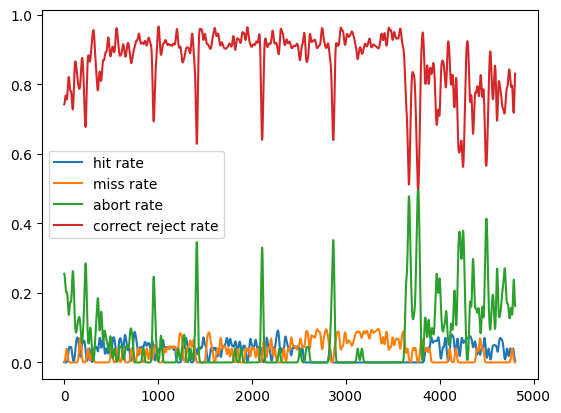

In [75]:
# Label licks as:
# - true positive (hits)
# - false negative (miss)
# - false positive (mostly abort)
# - true negative (correct reject)
tp = np.array(flashes.is_change & flashes.licked, dtype=float)
fn = np.array(flashes.is_change & ~flashes.licked, dtype=float)
fp = np.array(~flashes.is_change & flashes.licked, dtype=float)
tn = np.array(~flashes.is_change & ~flashes.licked, dtype=float)

# Smooth these over time with a Gaussian filter to estimate "rates"
from scipy.ndimage import gaussian_filter1d
sigma = 10
tpr = gaussian_filter1d(tp, sigma)
fnr = gaussian_filter1d(fn, sigma)
fpr = gaussian_filter1d(fp, sigma)
tnr = gaussian_filter1d(tn, sigma)

# Plot them
plt.plot(tpr, label="hit rate")
plt.plot(fnr, label="miss rate")
plt.plot(fpr, label="abort rate")
plt.plot(tnr, label="correct reject rate")
plt.legend()

Rather than looking at all four of these quantities, we often summarize them in terms of the _precision_ (here, the fraction of licks that were hits) and _recall_ (here, the fraction of changes that the mouse hit). 

Text(0.5, 0, 'stimulus presentation')

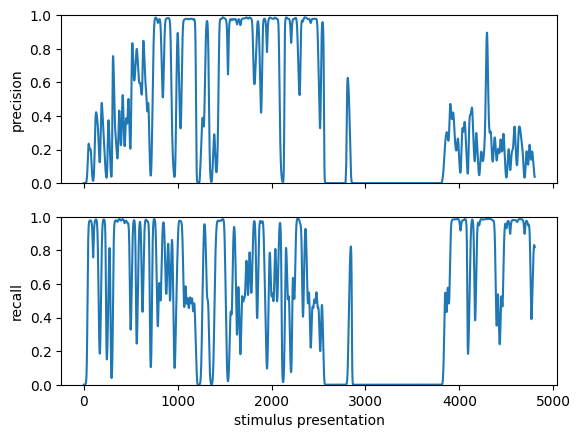

In [76]:
# Compute precision and recall rates
precision = tpr / (tpr + fpr + 1e-3)
recall = tpr / (tpr + fnr + 1e-3)

# Plot a smoothed estimate of the true positive (etc) rate over time
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(precision)
axs[0].set_ylabel("precision")
axs[0].set_ylim(0, 1)
axs[1].plot(recall)
axs[1].set_ylabel("recall")
axs[1].set_ylim(0, 1)
axs[1].set_xlabel("stimulus presentation")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem 3.1:</b> Is the mouse's performance consistent over the whole session? If not, how would you describe the changes in performance?
</div>

# 4. Model the behavior with a switching logistic regression

The idea behind this model is that the mouse's behavior varies with changes in its internal state. We don't directly observe this internal state (it's latent), but we can draw inferences about it based on the mouse's behavior. For example, if the mouse stops licking in response to stimulus changes, then we might infer that it has switched into an "inattentive" or "disenganged" state. The internal states we infer from behavior can offer clues for when we should look for changes in the underlying neural activity.

Let's formalize this with a hidden Markov model. Let 
- $y_t \in \{0,1\}$ specify whether or not the **mouse licked** on stimulus presentation $t$.
- $x_t \in \{-1,1\}$ specify whether or not the **stimulus changed** on stimulus presentation $t$.
- $z_t \in \{1, \ldots, K\}$ denote the **discrete internal state** of the mouse on stimulus presentation $t$.

We will model the relationship between licking ($y_t$) and stimulus changes ($x_t$) as a function of the internal state ($z_t$) with the following conditional distribution,
\begin{align*}
\Pr(y_t = 1 \mid x_t, z_t) &= \sigma(\alpha_{z_t} x_t + \beta_{z_t})
\end{align*}
where $\sigma(u) = \frac{1}{1+e^{-u}}$ is the _logistic function_, and $(\alpha_k, \beta_k)$ are parameters of a _logistic regression_. 

The logistic function is a "squashing" nonlinearity,

In [ ]:
# alpha: weight of the stimuluse (when the stim changes, how likely is the mouse going to lick or not lick)
# beta: bias - how much the mouse tend to lick regardless of the stim

Text(0.5, 1.0, 'logistic function')

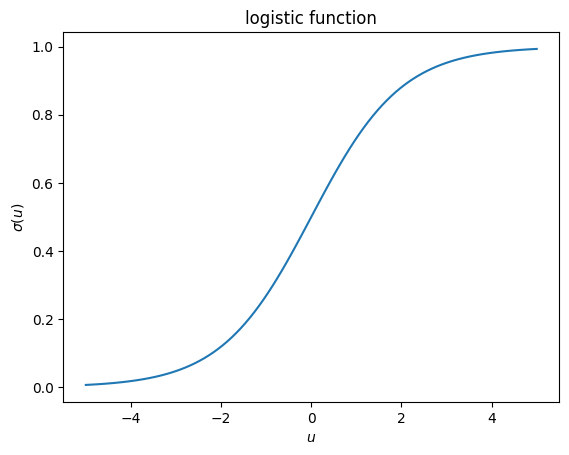

In [77]:
u = np.linspace(-5, 5, 100)
plt.plot(u, 1 / (1 + np.exp(-u)))
plt.xlabel("$u$")
plt.ylabel("$\sigma(u)$")
plt.title("logistic function")

Intuitively, when the linear function $\alpha_{z_t} x_t + \beta_{z_t}$ is much greater than zero, the probability of the mouse licking is high. When the linear function is much less than zero, the lick probability is low. 

Thus, $\alpha_k$ determines the mouse's _sensitivity_: how much a change in stimulus alters the mouse's lick probability in state $z_t = k$. Likewise, $\beta_k$ determines the mouse's _bias_ of the mouse toward licking or not licking in state $z_t = k$. 

We are interested in whether the sensitivity and bias of the mouse are changing over the course of the session. If they are, it might signal a change in internal state.

To do so, we'll fit a `LogisticRegressionHMM`, i.e. an HMM where each state corresponds to a different logistic regression mapping stimulus features to behavior.

In [78]:
from ssm_jax.hmm.models import LogisticRegressionHMM

### Construct the features that go into the logistic regression

In [79]:
# Encode stimulus change as +1 and no change as- 1
licked = flashes.licked.values.astype(int)
pm1 = lambda x: -1 + 2 * x
is_change = pm1(flashes.is_change.values.astype(float))

# For this model, it's important that the data is converted into a *JAX* array
y = jnp.array(licked)
X = jnp.column_stack([is_change])
X_names = ["is change"]
n_features = X.shape[1]

# Split the data into equal length batches
n_batches = 8
n_flashes = len(y) - (len(y) % n_batches)
batched_y = y[:n_flashes].reshape(n_batches, -1)
batched_X = X[:n_flashes].reshape(n_batches, -1, n_features)

In [96]:
num_states = 3
hmm = LogisticRegressionHMM.random_initialization(
    jr.PRNGKey(1234), num_states, feature_dim=n_features,
    emission_matrices_variance=1.0)

### Freeze the initial probabilities and transition matrix

We're looking for slowly changing internal states. We can enforce that by freezing the transition matrix to assign highest probability to self transitions. In our code, we can freeze parameters by calling `freeze()` on them.

In [97]:
# Fix the initial probabilities and transition matrix
hmm.initial_probs.value = jnp.ones(num_states) / num_states
hmm.initial_probs.freeze()

hmm.transition_matrix.value = 0.95 * jnp.eye(num_states) + 0.05 * jnp.ones((num_states, num_states)) / num_states
hmm.transition_matrix.freeze()

### Fit the model with EM

In [98]:
# Now call fit, again casting to JAX arrays
lps = hmm.fit_em(jnp.array(batched_y), features=jnp.array(batched_X), num_iters=200)

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0, 0.5, 'Log Probability')

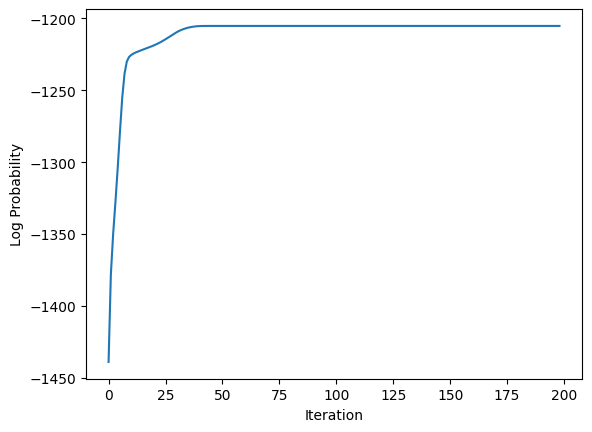

In [99]:
plt.plot(lps[1:])
plt.xlabel("Iteration")
plt.ylabel("Log Probability")

### Let's look at the inferred states!

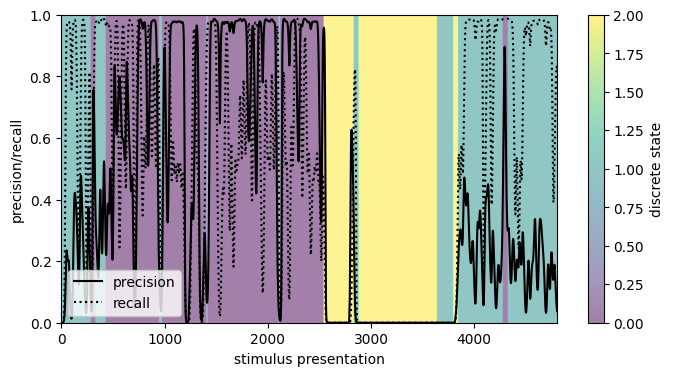

In [100]:
# Find the most likely discrete states given the learned model parameters
most_likely_states = hmm.most_likely_states(y, features=X)

# Overlay the precision and recall curves on top of the inferred states
plt.figure(figsize=(8, 4))
plt.imshow(most_likely_states[None, :], alpha=0.5, 
           extent=(0, len(y), 0, 1), aspect="auto")
plt.plot(precision, '-k', label="precision")
plt.plot(recall, ':k', label="recall")
plt.ylim(0, 1)
plt.ylabel("precision/recall")
plt.xlabel("stimulus presentation")
plt.legend(loc="lower left")

cb = plt.colorbar()
cb.set_label("discrete state")

As above, it's also a good idea to look at the posterior state probabilities.

Text(0.5, 0, 'stimulus presentation')

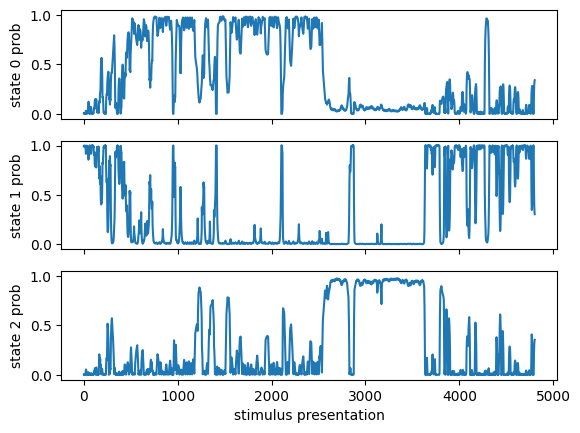

In [101]:
# Find the posterior distribution over states
posterior = hmm.smoother(y, features=X)

# Compare the true and inferred states
fig, axs = plt.subplots(hmm.num_states, 1, sharex=True)
for k, ax in enumerate(axs):
    ax.plot(posterior.smoothed_probs[:, k])
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel("state {} prob".format(k))
plt.xlabel("stimulus presentation")

### Let's dig into the model parameters

Specifically, we'll plot the weights associated with each feature under each discrete state.

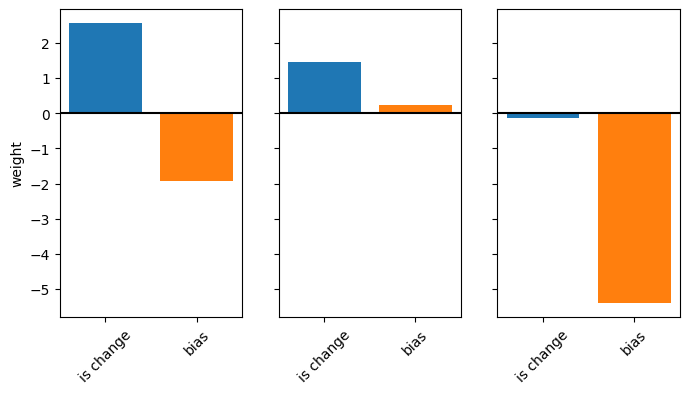

In [103]:
fig, axs = plt.subplots(1, hmm.num_states, sharey=True, figsize=(8, 4))
for k, ax in enumerate(axs):
    ax.bar(np.arange(X.shape[1]), hmm.emission_matrices.value[k])
    ax.bar(X.shape[1], hmm.emission_biases.value[k])
    ax.plot([-0.5, X.shape[1] + .5], [0, 0], '-k')
    ax.set_xlim(-0.5, X.shape[1] + .5)
    ax.set_xticks(np.arange(X.shape[1]+1))
    ax.set_xticklabels(X_names + ["bias"], rotation=45)
    if k == 0: ax.set_ylabel("weight")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem 4.1:</b> How does the mouse's behavior change across these three states? How does that manifest in the weights of the logistic regression?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem 4.2:</b> What other features could you add to the logistic regression? Modify the code above to add them, then refit the model and see how the inferred states and parameters change.
</div>

# 5. Cross validation

Perform cross validation to select the number of discrete states.

**This will take a few minutes so grab a coffee and hang tight!**

In [104]:
avg_test_log_probs = []
for num_states in range(1, 11):
    print("num states: ", num_states)
    
    test_log_probs = []
    for batch in trange(n_batches):
        # Extract all but this batch for training
        train_X = np.concatenate([batched_X[:batch], batched_X[batch+1:]])
        train_y = np.concatenate([batched_y[:batch], batched_y[batch+1:]])

        # Make an HMM
        hmm = LogisticRegressionHMM.random_initialization(
            jr.PRNGKey(0), num_states, feature_dim=n_features,
            emission_matrices_variance=1.0)
        
        # Fix the initial probabilities and transition matrix
        hmm.initial_probs.value = jnp.ones(num_states) / num_states
        hmm.initial_probs.freeze()
        hmm.transition_matrix.value = 0.95 * jnp.eye(num_states) + 0.05 * jnp.ones((num_states, num_states)) / num_states
        hmm.transition_matrix.freeze()
        
        # Fit the model
        lps = hmm.fit_em(jnp.array(train_y), features=jnp.array(train_X), num_iters=200, verbose=False)
        
        # Evaluate the log probability on held out data
        test_lp = hmm.marginal_log_prob(jnp.array(batched_y[batch]), 
                                        features=jnp.array(batched_X[batch]))
        test_log_probs.append(test_lp)
       
    # Store the average test log prob
    avg_test_log_probs.append(np.mean(test_log_probs))
        

num states:  1


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  2


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  3


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  4


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  5


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  6


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  7


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  8


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  9


  0%|          | 0/8 [00:00<?, ?it/s]

num states:  10


  0%|          | 0/8 [00:00<?, ?it/s]

Text(0, 0.5, 'average test log prob')

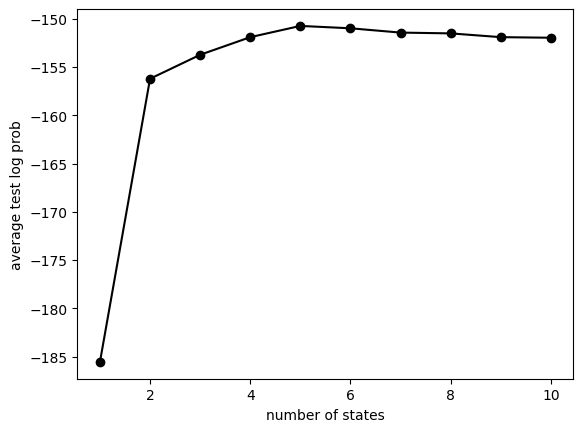

In [105]:
plt.plot(np.arange(1, len(avg_test_log_probs) + 1), avg_test_log_probs, '-ko')
plt.xlabel("number of states")
plt.ylabel("average test log prob")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem 5.1:</b> Do the cross-validation results match your expectations?  What other metrics could help guide your choice of number of states?
</div>

# 6. Thought Problems (and Project Ideas)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem 6.1:</b> You can think of the inferred behavioral states as features that have been derived from the behavioral data. These features are prime candidates to correlate with neural measurements. Do you think the neural responses to flashes/changes/omissions will differ from behavioral state to the next? 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem 6.2:</b> Likewise, we can correlate the inferred behavioral states with other aspects of the animal's behavior. Have we simply constructed a fancy way of extracting running speed and/or pupil size?
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Problem 6.3:</b> How do the behavioral states differ across mice or sessions? Are some mice better performers than others?
</div>